In [1]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import time
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import shap
import pickle

data = pd.read_pickle("dataframe.pkl")

In [2]:
X = data.drop(["TotalGHGEmissions","SiteEnergyUse(kBtu)"], axis=1)
Y = data["SiteEnergyUse(kBtu)"]

In [3]:
X = X.astype({col: 'int64' for col in X.select_dtypes(include=['int32']).columns})

In [4]:
X = pd.get_dummies(X)

In [5]:
num_cols = X.select_dtypes(include=['float64','int64']).columns
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

X = X.astype(float)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [7]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5)).mean()
    return rmse

def evaluation(y, predictions):
    mae = mean_absolute_error(y, predictions)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    r_squared = r2_score(y, predictions)
    return mae, mse, rmse, r_squared

In [8]:
models = pd.DataFrame(columns=["Model","MAE","MSE","RMSE","R2 Score","RMSE (Cross-Validation)", "Training Time (s)"])

In [9]:
alpha_values = {'alpha': [0.1, 1.0, 10.0, 50.0, 100.0]}
ridge = Ridge()

start_time = time.time()
grid_search = GridSearchCV(estimator=ridge, param_grid=alpha_values, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)
ridge_train_time = time.time() - start_time
print(f"Temps d'entraînement Ridge: {ridge_train_time:.4f} secondes")


best_alpha = grid_search.best_params_['alpha']
print(f"Meilleure valeur de alpha: {best_alpha}")

best_ridge_model = grid_search.best_estimator_

train_pred = best_ridge_model.predict(X_train)

mae, mse, rmse, r_squared = evaluation(y_train, train_pred)
rmse_cross_val = rmse_cv(ridge,X_train,y_train)
new_row = {"Model": "Ridge_train","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared, "RMSE (Cross-Validation)": rmse_cross_val, "Training Time (s)": ridge_train_time}
models = models._append(new_row, ignore_index=True)

predictions = best_ridge_model.predict(X_test)

mae, mse, rmse, r_squared = evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("-"*30)
rmse_cross_val = rmse_cv(ridge,X_train,y_train)
print("RMSE Cross-Validation:", rmse_cross_val)

new_row = {"Model": "Ridge","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared, "RMSE (Cross-Validation)": rmse_cross_val, "Training Time (s)": ridge_train_time}
models = models._append(new_row, ignore_index=True)

Temps d'entraînement Ridge: 0.0581 secondes
Meilleure valeur de alpha: 1.0
MAE: 4342183.909959584
MSE: 54894503799322.65
RMSE: 7409082.520752664
R2 Score: 0.6538437833910767
------------------------------
RMSE Cross-Validation: 12233349.839008313


In [10]:
svr_params = {'kernel': ['linear','rbf'], 'C': [1, 10],'gamma': ['auto','scale']}

total_combinations = np.prod([len(v) for v in svr_params.values()])
n_iter = min(5, total_combinations)

svr = SVR()

start_time = time.time()
randomized_search_svr = RandomizedSearchCV(estimator=svr, param_distributions=svr_params, scoring='neg_mean_squared_error', cv=3,n_jobs=-1,n_iter=n_iter)
randomized_search_svr.fit(X_train, y_train)
svr_train_time = time.time() - start_time
print(f"Temps d'entraînement SVR: {svr_train_time:.4f} secondes")

best_svr_model = randomized_search_svr.best_estimator_
print("Meilleurs paramètres (SVR):", randomized_search_svr.best_params_)

start_time = time.time()
train_pred_svr = best_svr_model.predict(X_train)
svr_pred_time = time.time() - start_time

mae_svr, mse_svr, rmse_svr, r_squared_svr = evaluation(y_train, train_pred_svr)
rmse_cross_val_svr = rmse_cv(svr, X_train, y_train)

new_row = {"Model": "SVR_train", "MAE": mae_svr, "MSE": mse_svr, "RMSE": rmse_svr, "R2 Score": r_squared_svr, "RMSE (Cross-Validation)": rmse_cross_val_svr, "Training Time (s)": svr_pred_time}
models = models._append(new_row, ignore_index=True)

start_time = time.time() 
predictions_svr = best_svr_model.predict(X_test)
svr_pred_time = time.time() - start_time

mae_svr, mse_svr, rmse_svr, r_squared_svr = evaluation(y_test, predictions_svr)
print("SVR - MAE:", mae_svr)
print("SVR - MSE:", mse_svr)
print("SVR - RMSE:", rmse_svr)
print("SVR - R2 Score:", r_squared_svr)
print("-" * 30)

rmse_cross_val_svr = rmse_cv(svr, X_train, y_train)
print("SVR - RMSE Cross-Validation:", rmse_cross_val_svr)

new_row = {"Model": "SVR", "MAE": mae_svr, "MSE": mse_svr, "RMSE": rmse_svr, "R2 Score": r_squared_svr, "RMSE (Cross-Validation)": rmse_cross_val_svr, "Training Time (s)": svr_pred_time}
models = models._append(new_row, ignore_index=True)

Temps d'entraînement SVR: 2.3444 secondes
Meilleurs paramètres (SVR): {'kernel': 'linear', 'gamma': 'auto', 'C': 10}
SVR - MAE: 5316315.634352291
SVR - MSE: 172416068871782.06
SVR - RMSE: 13130729.944362653
SVR - R2 Score: -0.08722895649848406
------------------------------
SVR - RMSE Cross-Validation: 20442192.37001856


In [11]:
rf_params = {
    'n_estimators': [10,15,20,25,30],
    'max_depth': [20,30,40],
    'min_samples_split': [2,3,4],
    'min_samples_leaf': [1,2,4]
}
rf = RandomForestRegressor()

grid_search_rf = GridSearchCV(estimator=rf, param_grid=rf_params, scoring='neg_mean_squared_error', cv=3)

start_time = time.time()
grid_search_rf.fit(X_train, y_train)
training_time = time.time() - start_time

best_rf_model = grid_search_rf.best_estimator_
best_params_rf = grid_search_rf.best_params_
print(f"Temps d'exécution: {training_time:.2f} secondes")
print("Meilleurs paramètres (RandomForest):", best_params_rf)

train_pred_rf = best_rf_model.predict(X_train)
mae_rf, mse_rf, rmse_rf, r_squared_rf = evaluation(y_train, train_pred_rf)
rmse_cross_val_rf = rmse_cv(rf,X_train, y_train)

new_row_rf = {
    "Model": "Random Forest (Train)",
    "MAE": mae_rf,
    "MSE": mse_rf,
    "RMSE": rmse_rf,
    "R2 Score": r_squared_rf,
    "RMSE (Cross-Validation)": rmse_cross_val_rf,
    "Training Time (s)": training_time
}
models = models._append(new_row_rf, ignore_index=True)

predictions_rf = best_rf_model.predict(X_test)
mae_rf_test, mse_rf_test, rmse_rf_test, r_squared_rf_test = evaluation(y_test, predictions_rf)

rmse_cross_val_rf = rmse_cv(rf,X_test, y_test)

new_row_rf_test = {
    "Model": "Random Forest (Test)",
    "MAE": mae_rf_test,
    "MSE": mse_rf_test,
    "RMSE": rmse_rf_test,
    "R2 Score": r_squared_rf_test,
    "RMSE (Cross-Validation)": rmse_cross_val_rf,
    "Training Time (s)": training_time
}
models = models._append(new_row_rf_test, ignore_index=True)

Temps d'exécution: 40.94 secondes
Meilleurs paramètres (RandomForest): {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 25}


In [12]:
xgb_params = {
    'n_estimators': [150,165,170,175,180,185],
    'learning_rate': [0.15,0.16,0.17,0.18,0.19,0.2],
    'max_depth': [1,3,4],
    'subsample': [0.5,0.6,0.7],
}

xgb = XGBRegressor()

randomized_search_xgb = RandomizedSearchCV(estimator=xgb, param_distributions=xgb_params,
                                           scoring='neg_mean_squared_error', cv=3, n_jobs=-1, n_iter=5)

start_time = time.time()
randomized_search_xgb.fit(X_train, y_train)
xgb_train_time = time.time() - start_time

print(f"Temps d'entraînement XGBRegressor: {xgb_train_time:.4f} secondes")
print("Meilleurs paramètres (XGBRegressor):", randomized_search_xgb.best_params_)

start_time = time.time()
train_pred_xgb = randomized_search_xgb.best_estimator_.predict(X_train)
xgb_pred_time_train = time.time() - start_time

mae_xgb, mse_xgb, rmse_xgb, r_squared_xgb = evaluation(y_train, train_pred_xgb)
rmse_cross_val_xgb = rmse_cv(xgb,X_train, y_train)

new_row_train = {
    "Model": "XGBRegressor_train",
    "MAE": mae_xgb,
    "MSE": mse_xgb,
    "RMSE": rmse_xgb,
    "R2 Score": r_squared_xgb,
    "RMSE (Cross-Validation)": rmse_cross_val_xgb,
    "Training Time (s)": xgb_train_time
}
models = models._append(new_row_train, ignore_index=True)

start_time = time.time()
predictions_xgb = randomized_search_xgb.best_estimator_.predict(X_test)
xgb_pred_time_test = time.time() - start_time

mae_xgb_test, mse_xgb_test, rmse_xgb_test, r_squared_xgb_test = evaluation(y_test, predictions_xgb)
rmse_cross_val_xgb = rmse_cv(xgb,X_test, y_test)

new_row_test = {
    "Model": "XGBRegressor",
    "MAE": mae_xgb_test,
    "MSE": mse_xgb_test,
    "RMSE": rmse_xgb_test,
    "R2 Score": r_squared_xgb_test,
    "RMSE (Cross-Validation)": rmse_cross_val_xgb,
    "Training Time (s)": xgb_pred_time_test
}
models = models._append(new_row_test, ignore_index=True)

Temps d'entraînement XGBRegressor: 1.0225 secondes
Meilleurs paramètres (XGBRegressor): {'subsample': 0.6, 'n_estimators': 185, 'max_depth': 3, 'learning_rate': 0.19}


In [13]:
models

,Model,MAE,MSE,RMSE,R2 Score,RMSE (Cross-Validation),Training Time (s)
0,Ridge_train,4.731006e+06,1.382434e+14,1.175770e+07,0.668437,1.223335e+07,0.058124
1,Ridge,4.342184e+06,5.489450e+13,7.409083e+06,0.653844,1.223335e+07,0.058124
2,SVR_train,6.822725e+06,4.463672e+14,2.112740e+07,-0.070566,2.044219e+07,0.015015
3,SVR,5.316316e+06,1.724161e+14,1.313073e+07,-0.087229,2.044219e+07,0.006003
4,Random Forest (Train),1.537168e+06,1.770196e+13,4.207370e+06,0.957544,1.148329e+07,40.941418
5,Random Forest (Test),3.194830e+06,4.452058e+13,6.672374e+06,0.719260,9.407890e+06,40.941418
6,XGBRegressor_train,2.067084e+06,1.077878e+13,3.283106e+06,0.974148,1.096774e+07,1.022466
7,XGBRegressor,3.519863e+06,5.158119e+13,7.182004e+06,0.674737,9.333442e+06,0.018023


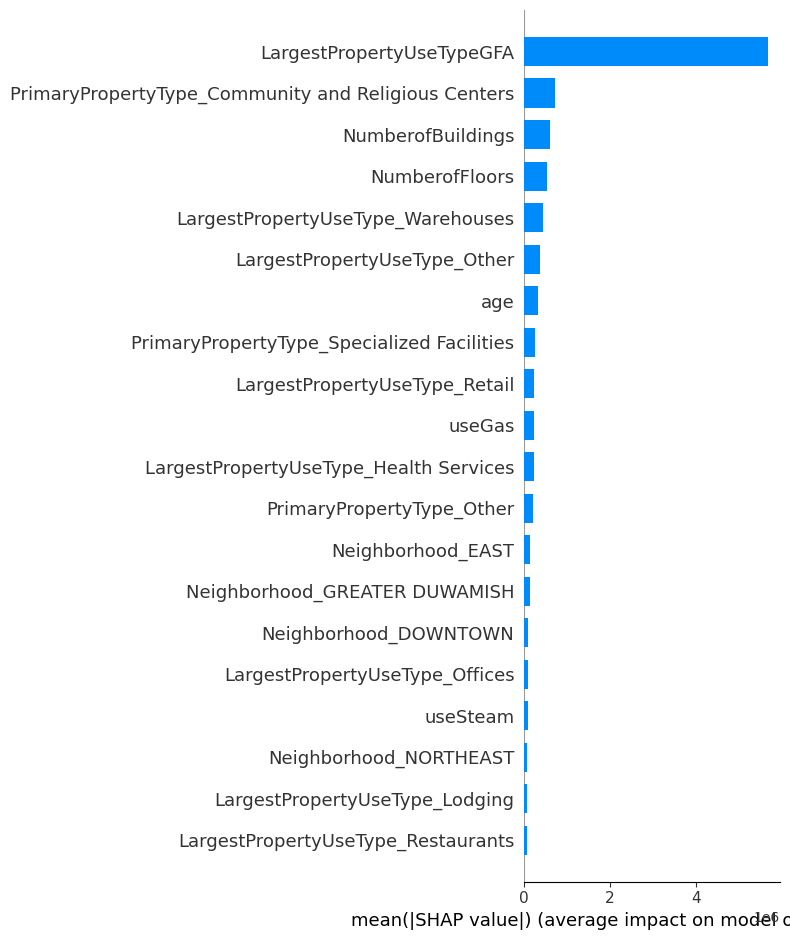

In [14]:
explainer = shap.TreeExplainer(best_rf_model)

shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test,plot_type='bar')

In [15]:
EnergyStarScore_data = pd.read_pickle("data_ess.pkl")

X_energy = EnergyStarScore_data.drop(["TotalGHGEmissions","SiteEnergyUse(kBtu)"], axis=1)
Y_energy = EnergyStarScore_data["TotalGHGEmissions"]
X_energy = X_energy.astype({col: 'int64' for col in X_energy.select_dtypes(include=['int32']).columns})

In [16]:
X_energy = pd.get_dummies(X_energy)

num_cols = X_energy.select_dtypes(include=['float64']).columns
scaler = StandardScaler()
X_energy[num_cols] = scaler.fit_transform(X_energy[num_cols])

X_energy= X_energy.dropna()
Y_energy = Y_energy.loc[X_energy.index]

test_energy = pd.DataFrame(columns=["Model","MAE","MSE","RMSE","R2 Score"])

In [17]:
X_without_energy = X_energy.drop(columns=["ENERGYSTARScore"])

X_train, X_test, y_train, y_test = train_test_split(X_energy, Y_energy, test_size=0.2, random_state=42)

rf_with = RandomForestRegressor(**best_params_rf)
model_with = rf_with.fit(X_train, y_train)
pred_with = model_with.predict(X_test)

mae_rf, mse_rf, rmse_rf, r_squared_rf= evaluation(y_test, pred_with)
new_row_rf = {
    "Model": "Random Forest (With)",
    "MAE": mae_rf,
    "MSE": mse_rf,
    "RMSE": rmse_rf,
    "R2 Score": r_squared_rf
}
test_energy = test_energy._append(new_row_rf, ignore_index=True)

X_train_reduced = X_train.drop(columns=["ENERGYSTARScore"])
X_test_reduced = X_test.drop(columns=["ENERGYSTARScore"])

rf_without = RandomForestRegressor(**best_params_rf)
rf_without.fit(X_train_reduced, y_train)
pred_without = rf_without.predict(X_test_reduced)

mae_rf, mse_rf, rmse_rf, r_squared_rf = evaluation(y_test, pred_without)
new_row_rf = {
    "Model": "Random Forest (Without)",
    "MAE": mae_rf,
    "MSE": mse_rf,
    "RMSE": rmse_rf,
    "R2 Score": r_squared_rf
}
test_energy = test_energy._append(new_row_rf, ignore_index=True)
test_energy

,Model,MAE,MSE,RMSE,R2 Score
0,Random Forest (With),72.224885,53203.055440,230.657875,0.473822
1,Random Forest (Without),75.677377,54129.708289,232.657921,0.464657


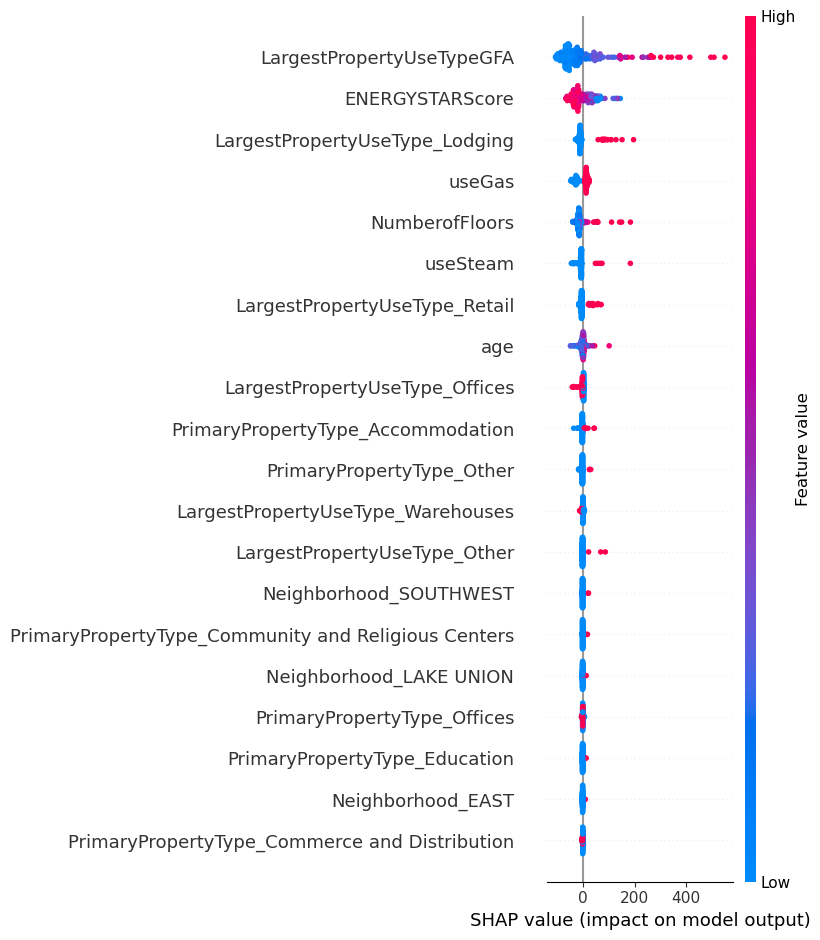

In [18]:
explainer = shap.TreeExplainer(model_with)

shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

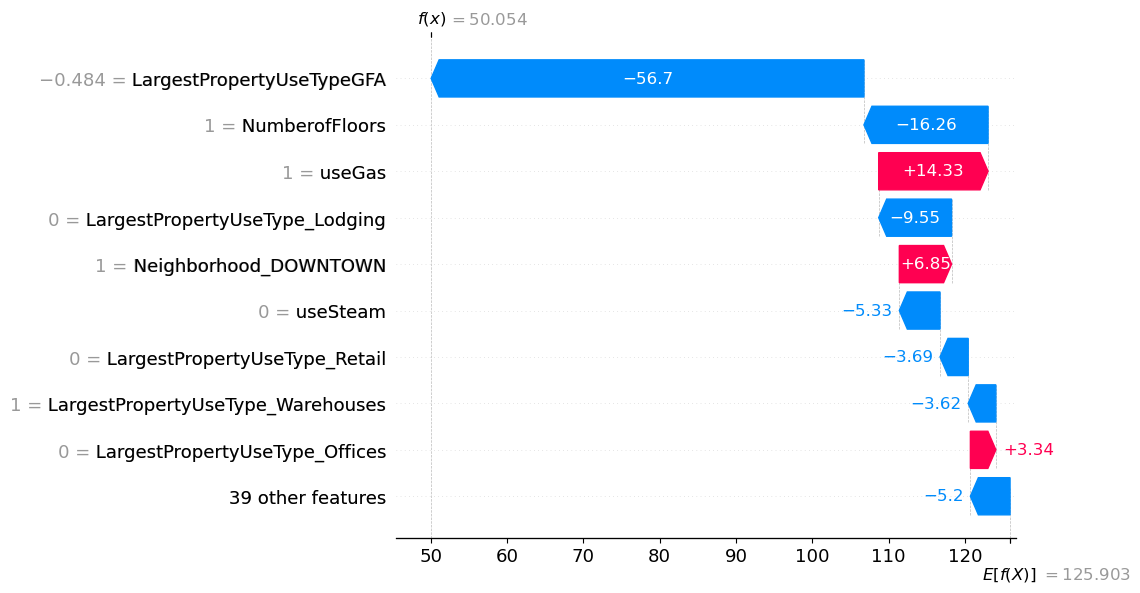

In [19]:
explainer = shap.TreeExplainer(rf_with)
# Obtenir les valeurs SHAP
shap_values = explainer(X_test)

# Créer un objet Explanation pour la première instance
try:
    # Récupérer l'instance
    data_instance = X_test.iloc[0].to_numpy()

    # Convertir toutes les données en float
    data_instance_float = data_instance.astype(float)

    base_value_scalar = float(shap_values[0].base_values)
    # Créer l'objet Explanation
    exp = shap.Explanation(
        values=shap_values[0].values,
        base_values=base_value_scalar,
        data=data_instance_float,
        feature_names=X_test.columns
    )

    # Afficher le waterfall plot pour la première instance de X_test
    shap.plots.waterfall(exp)

except Exception as e:
    print("Erreur lors de la création de l'objet Explanation ou du plot:", e)